# Supporting code for submission

This notebook uses our publically available "NanoImagingPack" library, in
addition to standard Anaconda packages. Available at
https://gitlab.com/bionanoimaging/nanoimagingpack/-/tree/feature2-calreadnoise .
Installation instructions are provided there. Current commit is
2005996da7a65af3b6322713f05499fa62e7971b

It also uses the tabulate package to generate tables from the data.

The notebook is divided into sections, which output results. Data is loaded from the
"data" subfolder, and figures are saved to the "output" folder. The code
generates all figures included in the submission.

Up until the "camera" section, all code can simply be run linearly.

But for the camera calibration, it s necessary to run only the cells associated
with loading a particular image stack before performing the "Save plots" and
"Quantum efficiency" sections. This is necessary to avoid loading too much data
in memory, but keeps thing simple by having just one procedure for multiple
plots and quantum efficiency calculations.



In [ ]:
import numpy as np
import NanoImagingPack as nip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import dateutil
import pathlib
import datetime
import scipy.stats

import sys

# %matplotlib qt
# %gui qt

# Define the input and output paths
data_dir = pathlib.Path("data")
out_dir = pathlib.Path("output")
out_dir.mkdir(exist_ok=True)

In [121]:
# Define some parameters for the plot format

CM = 1/2.54
FIGSIZE = 8.9*CM, 3/4*8.9*CM  # 89mm, 3:4 ratio
FIGSIZE_LARGE = 13*CM, 3/4*13*CM  # 89mm, 3:4 ratio


mpl.rcParams['axes.linewidth'] = 1

mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.labelweight'] = 'normal'

mpl.rcParams['axes.titlesize'] = 10.5
mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fontsize'] = 8


mpl.rcParams['lines.linewidth'] = 1

In [122]:
# function definitions that we will be useful for the analysis

def read_power(power_log_file, time_offset=datetime.timedelta(0), responsivity=None):
    power_data = pd.read_csv(power_log_file, sep="\t", names=["Power","Time"], skiprows=4)
    lines = open(power_log_file, "r").readlines(500)
    start_time = lines[0].split("\t")[1]
    start_time = dateutil.parser.parse(start_time)
    
    for line in lines:
        if "wavelength" in line:
            pm_wavelength = float(line.split("\t")[1].strip("nm\n"))
    
    time = start_time + pd.to_timedelta(power_data.Time, unit="ms")
    power_data.Time = time + time_offset
    power_data = power_data.set_index("Time")
    if responsivity is not None:
        wl_responsivity = np.interp(pm_wavelength, responsivity_cert.index, responsivity_cert)
        power_data["Current"] = power_data*wl_responsivity
    return power_data, pm_wavelength

def read_power_multifile(log_files, time_offset=datetime.timedelta(0), responsivity=None):
    data = []
    for file in log_files:
        data.append(read_power(file, time_offset=time_offset, responsivity=responsivity))
    power_data = pd.concat([a[0] for a in data])
    pm_wavelengths = np.array([a[1] for a in data])
    assert (pm_wavelengths==pm_wavelengths[0]).all()
    return power_data, pm_wavelengths[0]

def power_read_subtract_dark(bright_file, dark_file):
    """A helper function to evaluate a common experiment. The dark current/power
    is measured and subtracted from the bright measurement. Samples are taken in
    the early hours of the morning."""
    p_bright, b_wavelength = read_power(bright_file)
    p_dark, d_wavelength = read_power(dark_file)
    assert b_wavelength==d_wavelength
    # pick first day, 3am
    p_bright = float(p_bright[:p_bright.index[0]+datetime.timedelta(days=1)].between_time('3:00', '3:30').mean())
    p_dark = float(p_dark[:p_dark.index[0]+datetime.timedelta(days=1)].between_time('3:00', '3:30').mean())
    return p_bright-p_dark, b_wavelength



class pm_container:
    """
    Container object for photon flux calculation. It requires a power density
    spectrum, a powerreading from the power meter, and the responsivity spectrum
    of the photodiode
    """
    unbiased_power = 0
    pm_wavelength = 0
    def __init__(self):
        return

    def load_responsivity(self, responsivity):
        self.responsivity = responsivity

    def load_emission_spectrum(self, spec_obj):
        "Uses spectral power density"
        self.pw_mean_wl = spec_obj.pw_mean_wl
        self.normalised_spec = spec_obj.normalised
        VIS_RANGE = spec_obj.VIS_RANGE
        em_spec = spec_obj.filtered
        em_spec = pd.DataFrame(em_spec, columns=["Power density"])
        em_spec["Responsivity"] = np.interp(em_spec.index, self.responsivity.index, self.responsivity)
        em_spec["Response"] = em_spec["Responsivity"]*em_spec["Power density"]
        self.spectrum = em_spec
        spec_density = np.gradient(em_spec.index)
        self.pw_mean_responsivity = ((em_spec["Responsivity"]*em_spec["Power density"]*spec_density)[VIS_RANGE].sum()
                               /(em_spec["Power density"]*spec_density)[VIS_RANGE].sum())   
        
    def process(self):
        assumed_responsivity = np.interp(self.pm_wavelength, self.responsivity.index, self.responsivity)
        # self.power_data["Current"] = self.power_data["Power"]*wl_responsivity
        correction_factor = assumed_responsivity/self.pw_mean_responsivity
        corrected_mean_power = float(self.unbiased_power*correction_factor)
        self.corrected_power = corrected_mean_power
        from scipy.constants import c, h
        ph_en = (h*c)/(self.pw_mean_wl*1e-9)
        self.photon_flux = corrected_mean_power/ph_en


# Process spectra

In [123]:
class spec_obj:
    VIS_RANGE = slice(370,750) #from spectrometer brochure
    "A class for a series of spectra"
    def __init__(self, datapath):
        files = pathlib.Path(datapath).glob("*.spz")
        files = list(files)
        files.sort()
        self.files = files
        self.result = None

    def read_files(self, start=None, end=None):
        # The early hours are a good time when there is little temperatur
        # fluctuation.
        # First read temperature and time
        temperature_curve = []
        for file in self.files:
            with open(file, "r") as fileobj:
                headlines = fileobj.readlines(600)
            temperature = float(headlines[17].split("\t")[1])
            dt = dateutil.parser.parse(headlines[12].split("\t")[1])
            temperature_curve.append((dt, temperature))
        temperature_curve = pd.DataFrame(temperature_curve, columns=["Time","Temp"])
        temperature_curve = temperature_curve.set_index("Time")
        temperature_curve["FileIndex"] = range(temperature_curve.shape[0])
    
        self.temperature_curve = temperature_curve

        # Then read the actual spectra
        # which files to read
        ixs = np.array(self.temperature_curve.between_time(start, end)["FileIndex"])
  
        eval_files = self.files[min(ixs):max(ixs)]
        print(f"Reading {len(eval_files)} spectrum files")
        raw_specs = []
        for ix, file in enumerate(eval_files):
            raw_specs.append(pd.read_csv(file, header=18, delimiter="\t", index_col=0))
        raw_specs = pd.concat(raw_specs, axis=1)
            
        # self.raw_specs = raw_specs
        self.mean_spec = raw_specs.mean(axis=1)
        return

    def background_filter(self, background_spec=0, window_size=7):
        # median filter is a good way to removes spikes
        self.unbiased_spec = self.mean_spec-background_spec
        self.filtered = self.unbiased_spec.rolling(7).median()
        # self.filtered = pd.Series(filtered_sig, index=self.avg_spec.index)
        self.normalised = self.filtered[self.VIS_RANGE]/self.filtered[self.VIS_RANGE].max()

        # calculate the power-weighted mean wavelength
        wavelength = self.normalised.index
        wl_density = np.gradient(wavelength)
        power_density = self.normalised

        self.pw_mean_wl = ((power_density*wl_density*wavelength)[self.VIS_RANGE].mean()/
                (power_density*wl_density)[self.VIS_RANGE].mean())



## Read spectra of calibration sources

In [130]:
# dark background acquisition
dark_o = spec_obj(data_dir/r"spectra\dark") #27.15C
dark_o.read_files(start="2:30", end="4:30")

Reading 552 spectrum files


In [136]:
# green calibration source no. 001
g001_o = spec_obj(data_dir/r"spectra\g001") #27.11
g001_o.read_files(start="2:30", end="4:30")
g001_o.background_filter(dark_o.mean_spec)
print(f"Power weighted mean wavelength: {g001_o.pw_mean_wl:.2f}")

Reading 552 spectrum files
Power weighted mean wavelength: 537.27


In [140]:
# green calibration source no. 002
g002_o = spec_obj(data_dir/r"spectra\g002") #27.16C
g002_o.read_files(start="2:30", end="4:30")
g002_o.background_filter(dark_o.mean_spec)
print(f"Power weighted mean wavelength: {g002_o.pw_mean_wl:.2f}")
print(f"Deviation from g001: {np.abs(g001_o.pw_mean_wl-g002_o.pw_mean_wl)/g001_o.pw_mean_wl: .2%}")

Reading 552 spectrum files
Power weighted mean wavelength: 540.50
Deviation from g001:  0.60%


In [138]:
# blue calibration source no. 001
b001_o = spec_obj(data_dir/r"spectra\b001") #27.29C
b001_o.read_files(start="2:30", end="4:30")
b001_o.background_filter(dark_o.mean_spec)
print(f"Power weighted mean wavelength: {b001_o.pw_mean_wl:.2f}")

Reading 552 spectrum files
Power weighted mean wavelength: 460.94


In [152]:
# green source no. 001 was measured again some months later. The background spectrum was also acquired again

dark_o_v2 = spec_obj(data_dir/r"spectra\dark_v2") #28.22
dark_o_v2.read_files(start="2:30", end="4:30")

g001_o_v2 = spec_obj(data_dir/r"spectra\g001_v2") #28.38C
g001_o_v2.read_files(start="2:30", end="4:30")
g001_o_v2.background_filter(dark_o_v2.mean_spec)
print(f"Power weighted mean wavelength: {g001_o_v2.pw_mean_wl:.2f}")
print(f"Deviation from previous measurement: {np.abs(g001_o_v2.pw_mean_wl-g001_o.pw_mean_wl)/g001_o.pw_mean_wl: .2%}")

Reading 514 spectrum files
Reading 513 spectrum files
Power weighted mean wavelength: 541.43
Deviation from previous measurement:  0.77%


## Plot and save spectra

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


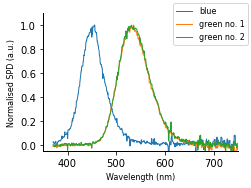

In [59]:
fig, ax = plt.subplots(1, figsize=FIGSIZE)
b001_o.normalised.plot(ax=ax, label="blue")
g001_o.normalised.plot(ax=ax, label="green no. 1")
g002_o.normalised.plot(ax=ax, label="green no. 2")
ax.set_xlim(350, 750)
ax.set_ylim(-0.05, 1.1)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Normalised SPD (a.u.)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
fig.legend()

fig.savefig(out_dir/"combined_spec.eps")
fig.savefig(out_dir/"combined_spec.png", dpi=800)

## Repeatability of power weighted mean wavelength measurement

In [12]:
paths = list((data_dir/"spectra/repeatability").glob("*"))

wl_list = []
for path in paths:
    so = spec_obj(path)
    so.read_files(start="2:30", end="4:30")
    so.background_filter(dark_o.mean_spec)
    wl_list.append(so.pw_mean_wl)
wl_list = np.array(wl_list)


Reading 552 spectrum files
Reading 552 spectrum files
Reading 552 spectrum files
Reading 552 spectrum files
Reading 551 spectrum files
Reading 552 spectrum files
Reading 552 spectrum files
Reading 552 spectrum files
Reading 552 spectrum files


In [13]:
fluctuation = wl_list.std()/wl_list.mean()
print(f"{fluctuation:.1%} fluctuation in power-weighted mean wavelength")

0.7% fluctuation in power-weighted mean wavelength


## Plastic light attenuation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


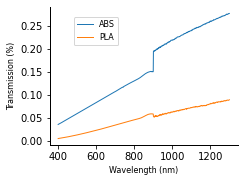

In [159]:
def read_spectrophotometer(file):
    data = pd.read_csv(file, sep=";", decimal=",", index_col=0, skiprows=19,
                        skipfooter=39, names=["Wavelength", "Transmission"], engine="python",
                        converters={0:lambda s:float(s.replace(",",".")), 1:lambda s:float(s.replace(",","."))})

    data = data.sort_index()
    data = data/100
    return data

abs_transmission = read_spectrophotometer(data_dir/"plastic_characterisation/spectral_transmission/abs.csv")
pla_transmission = read_spectrophotometer(data_dir/"plastic_characterisation/spectral_transmission/pla.csv")


fig, ax = plt.subplots(1, figsize=FIGSIZE)

ax.plot(pla_transmission[400:1300].index, abs_transmission[400:1300], label="ABS")
ax.plot(pla_transmission[400:1300].index, pla_transmission[400:1300], label="PLA")

ax.set_ylabel("Transmission (%)")
ax.set_xlabel("Wavelength (nm)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.legend(loc=[0.3, 0.75])
fig.tight_layout()

fig.savefig(out_dir/"plastic_transmission.eps")
fig.savefig(out_dir/"plastic_transmission.png", dpi=800)

Exctinction coefficient: -20.6/mm


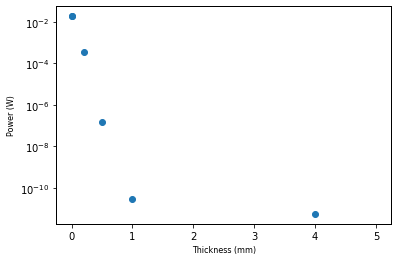

In [117]:
#ABS extinction
datafile = data_dir/"plastic_characterisation/attenuation/ABS.csv"
transition_points = [ #ABS
(0.0, '2021-11-02 20:07:00'),
(0.2, '2021-11-02 20:07:30.869000'),
(0.5, '2021-11-02 20:08:00'),
(1.0, '2021-11-02 20:08:30.347000'),
(1.5, '2021-11-02 20:09:00.801000'),
(2.0, '2021-11-02 20:09:30.310000'),
(2.5, '2021-11-02 20:09:59'),
(3.0, '2021-11-02 20:10:31.084000'),
(4.0, '2021-11-02 20:11:01.110000'),
(5.0, '2021-11-02 20:11:31.160000'),
(0.0, '2021-11-02 20:11:59'),
]
FIT_INDECES = slice(None,3)



power_data, pm_wavelength = read_power(datafile)

DUR = datetime.timedelta(seconds=15)
DELAY = datetime.timedelta(seconds=1)

transition_points = pd.DataFrame(transition_points, columns=["Thickness", "Time"])
transition_points["Time"] = pd.to_datetime(transition_points["Time"])

for ix, point in transition_points.iterrows():
    dt = point["Time"]
    meanpower = float(power_data[dt-DUR-DELAY:dt-DELAY].mean())
    transition_points.loc[ix, "Power"] = meanpower

plt.semilogy(transition_points["Thickness"], transition_points["Power"], "o")
plt.xlabel("Thickness (mm)")
plt.ylabel("Power (W)")
# fit on loigarithmic data
fit_data = transition_points.loc[FIT_INDECES]
slope, offset = np.polyfit(fit_data["Thickness"], np.log(fit_data["Power"]), 1)
print(f"Exctinction coefficient: {slope:.1f}/mm")

Exctinction coefficient: -6.3/mm


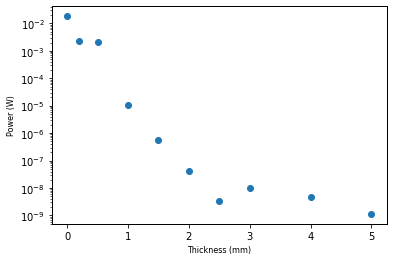

In [118]:
#PLA extinction
datafile = data_dir/"plastic_characterisation/attenuation/PLA.csv"
transition_points = [ #PLA
(0.0, '2021-11-02 20:15:02.467000'),
(0.2, '2021-11-02 20:15:30.467000'),
(0.5, '2021-11-02 20:16:01.367000'),
(1.0, '2021-11-02 20:16:31.424000'),
(1.5, '2021-11-02 20:17:01.595000'),
(2.0, '2021-11-02 20:17:31.427000'),
(2.5, '2021-11-02 20:18:01.389000'),
(3.0, '2021-11-02 20:18:37.079000'),
(4.0, '2021-11-02 20:19:01.334000'),
(5.0, '2021-11-02 20:19:30.961000'),
]
FIT_INDECES = slice(None,6)


power_data, pm_wavelength = read_power(datafile)

DUR = datetime.timedelta(seconds=15)
DELAY = datetime.timedelta(seconds=1)

transition_points = pd.DataFrame(transition_points, columns=["Thickness", "Time"])
transition_points["Time"] = pd.to_datetime(transition_points["Time"])

for ix, point in transition_points.iterrows():
    dt = point["Time"]
    meanpower = float(power_data[dt-DUR-DELAY:dt-DELAY].mean())
    transition_points.loc[ix, "Power"] = meanpower

plt.semilogy(transition_points["Thickness"], transition_points["Power"], "o")
plt.xlabel("Thickness (mm)")
plt.ylabel("Power (W)")
# fit on loigarithmic data
fit_data = transition_points.loc[FIT_INDECES]
slope, offset = np.polyfit(fit_data["Thickness"], np.log(fit_data["Power"]), 1)
print(f"Exctinction coefficient: {slope:.1f}/mm")



# Process Power meter logs

## Temperature dependence

In [14]:
#offset of power_meter from CEST, taken from photo
#cam: 16:35:06
#pm: 15:34:03

time_offset = dateutil.parser.parse("16:35:06")-dateutil.parser.parse("15:34:03")
POWER_FILE = data_dir/r"temperature_exp\2019-08-06_power.csv"
TEMP_FILE = data_dir/r"temperature_exp\2019-08-06_Temperature.csv"

power, wl = read_power(POWER_FILE, time_offset=time_offset)
temp_data = pd.read_csv(TEMP_FILE, sep=",", names=["Time", "Temp", "Hum"], 
                        skiprows=0, decimal=".", parse_dates=['Time'], 
                        date_parser=dateutil.parser.parse, index_col="Time")
      



2.2% per deg C


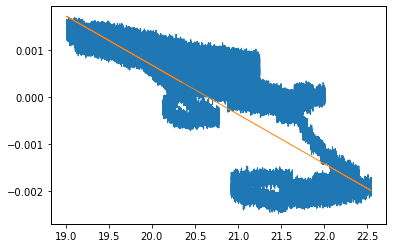

In [15]:
power["Relative power"] = (power["Power"]-power["Power"].mean())/power["Power"].mean()
# power["Relative power"].plot()

power["Temperature"] = np.interp(power.index, temp_data.index, temp_data.Temp)
measurement_slice = power['2019-08-02 10:00': '2019-08-06']

coeffs = np.polyfit(measurement_slice["Temperature"], measurement_slice["Relative power"], 1)

print(f"{coeffs[1]*100:.1f}% per deg C")

plt.plot(measurement_slice["Temperature"], measurement_slice["Relative power"])
plt.plot(measurement_slice["Temperature"], np.polyval(coeffs, measurement_slice["Temperature"]))


## Decay experiment

In [69]:
# The data is split across a number of files which need to be joined
PM_FILES = list((data_dir/"decay_exp").glob("*.csv"))
#offset of power_meter from EST, taken from photo
#cam: 16:35:06
#pm: 15:34:03

time_offset = dateutil.parser.parse("16:35:06")-dateutil.parser.parse("15:34:03")
power_data, wl = read_power_multifile(PM_FILES, time_offset=time_offset)

# Add days column for ease with plotting
power_data["days"] = (power_data.index-power_data.index[0]) / np.timedelta64(1, 'D')

### Decay considerations

In [70]:
HALFLIFE = pd.Timedelta('4500 d')
#https://www.nist.gov/pml/radionuclide-half-life-measurements/radionuclide-half-life-measurements-data

tau = HALFLIFE/np.log(2)
print(f"Decay constant: {tau / np.timedelta64(1, 'D'):.0f} days")

ra_decay_per_month = np.exp(-np.timedelta64(1, 'M')/tau)-1
print(f"Radioactive relative decay per month: {ra_decay_per_month:.2%}")


Decay constant: 6492 days
Radioactive relative decay per month: -0.47%


In [71]:
# We will sample once a day for 30 minutes
# the early hours are a good time to sample data
power_data = power_data.between_time('3:00', '3:30')
power_data = power_data.resample('D').apply(lambda x: np.mean(x))

Change in power from 19th to 20th: -0.57%%


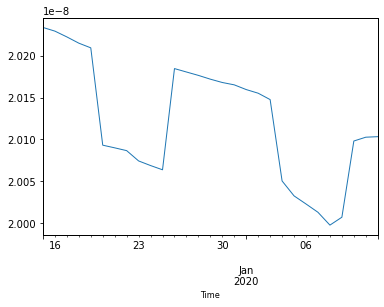

In [72]:
# There are two destinct power drops over the holiday period 
power_data["Power"]["2019-12-15": "2020-01-12"].plot()

# Power drop from the 19th to the 20th


power_19 = power_data["Power"]["2019-12-19"]
power_20 = power_data["Power"]["2019-12-20"]

relative_change = (power_20-power_19)/power_19

print(f"Change in power from 19th to 20th: {relative_change:.2%}%")

In [73]:
td = power_data.index-power_data.index[0]
dec_data = pd.DataFrame(index=power_data.index)

In [102]:
print(f"Expected decay {np.exp(-np.ptp(power_data.index)/tau)-1:.1%}")
print(f'Experimental decay {power_data["Power"].iloc[-1]/power_data["Power"].iloc[0]-1:.1%}')
tau_exp = -np.ptp(power_data.index)/np.log(power_data["Power"].iloc[-1]/power_data["Power"].iloc[0])
halflife_exp = float(tau_exp)/1e9/(365.25*24*3600)*np.log(2)
print(f"Corresponding half life: {halflife_exp:.1f} years")


Expected decay -2.7%
Experimental decay -3.9%
Corresponding half life: 8.4 years


### Iterative fit

Iteration 1.335E-03
Iteration 6.679E-04
Iteration 4.838E-04
Iteration 4.838E-04
Iteration 4.838E-04
Iteration 4.838E-04
Iteration 4.838E-04
Iteration 4.838E-04
Iteration 4.838E-04
Iteration 4.838E-04
RMSD 4.838E-04
Experimental relative decay per month: -0.69%


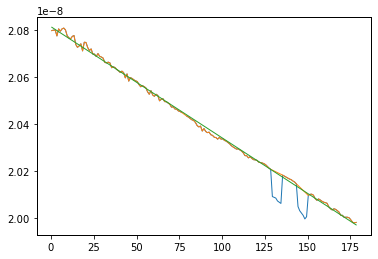

In [96]:
# Iterative linear fit, excluding 3 sigma outliers
SIGMA_THRESHOLD = 3

reduced_data = power_data.dropna()

def fit_exclude(input_data):
    a,b = np.polyfit(input_data["days"], input_data["Power"], 1)
    residuals = input_data["Power"]-(input_data["days"]*a+b)
    print(f"Iteration {np.std(residuals)/b:.3E}")
    sigma = np.std(residuals)
    input_data = input_data[np.abs(residuals) < SIGMA_THRESHOLD*sigma]
    return input_data

for i in range(10):
    reduced_data = fit_exclude(reduced_data)
    
    
# new residuals
linfit_coeffs = np.polyfit(reduced_data["days"], reduced_data["Power"], 1)
fitline = np.polyval(linfit_coeffs, reduced_data["days"])
residuals = reduced_data["Power"] - fitline
# RMSD root mean square deviation
print(f"RMSD {np.std(residuals)/linfit_coeffs[1]:.3E}")


plt.close("all")
plt.plot(power_data["days"], power_data["Power"],
         reduced_data["days"], reduced_data["Power"],
         reduced_data["days"], fitline)

decay_per_month = linfit_coeffs[0]/linfit_coeffs[1]*365.25/12
print(f"Experimental relative decay per month: {decay_per_month:.2%}")

In [97]:
# The half life can be estimated from a fit from the logarithm of the data

slope, intersect = np.polyfit(reduced_data["days"], np.log(reduced_data["Power"]), 1)

tau_measured = 1/slope
half_life_measured = -tau_measured*np.log(2)

print(f"Estimated Half-life: {half_life_measured:.0f} days ({pd.Timedelta(days=half_life_measured)/np.timedelta64(1, 'Y'):.1f} years)")


Estimated Half-life: 2991 days (8.2 years)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


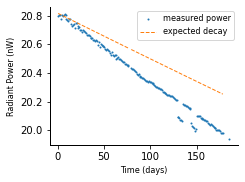

In [62]:
# create a plot with the expected decay and measured decay

power_data["Expected Decay"] = np.exp(-td/tau)*linfit_coeffs[1]

fig = plt.figure(figsize=FIGSIZE)
ax = fig.gca()

ax.plot(power_data["days"], power_data["Power"]/1e-9, ".", markersize=2, label="measured power")
ax.plot(power_data["days"], power_data["Expected Decay"]/1e-9, 
        ls="--", label="expected decay")        

# ax.plot(power_data["days"], power_data["Power"]/1e-9, ".", markersize=6)
# ax.plot(power_data["days"], power_data["Expected Decay"]/1e-9, 
#         color=mpl_style.leibniz_colors["green"], ls="--")

plt.ylabel("Radiant Power (nW)")
plt.xlabel("Time (days)")
# plt.title("Photodiode signal over time")
plt.legend()

# plt.tight_layout(pad=1.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.tight_layout()
# plt.tight_layout(rect=[0, 0.03, 0.95, 0.93])
# fig.savefig("trit_decay.png", dpi=128)

fig.savefig(out_dir/"decay_GTLS.eps")
fig.savefig(out_dir/"decay_GTLS.png", dpi=800)

### Long term monitoring

In [21]:
f_b0 = data_dir/r"source_measurements\2020-07\g-001.csv"
f_d0 = data_dir/r"source_measurements\2020-07\dark.csv"


f_b1 = data_dir/r"source_measurements\2020-08\g-001.csv"
f_d1 = data_dir/r"source_measurements\2020-08\dark.csv"

f_d2 = data_dir/r"source_measurements\2021-05\PM1_sensor1\dark.csv"
f_b2 = data_dir/r"source_measurements\2021-05\PM1_sensor1\g-001.csv"

darks = [f_d0, f_d1, f_d2]
brights = [f_b0, f_b1, f_b2]

In [22]:
power_predictability = []

for d_file, b_file in zip(darks, brights):
    d_data, pm_wavelength = read_power(d_file)
    b_data, pm_wavelength = read_power(b_file)
    d_mean = d_data[:d_data.index[0]+datetime.timedelta(days=1)].between_time('3:00', '3:30').mean()
    b_mean = b_data[:b_data.index[0]+datetime.timedelta(days=1)].between_time('3:00', '3:30').mean()
    unbiased_mean = b_mean-d_mean
    res_frame = pd.DataFrame([unbiased_mean], index=[b_data.index[0].date()])
    power_predictability.append(res_frame)

power_predictability = pd.concat(power_predictability)

In [23]:
# use the linear fit from earlier to predict the power of the mounted source g001

power_predictability["days"] = (power_predictability.index-power_predictability.index[0]) / np.timedelta64(1, 'D')
power_predictability["Predicted"] = power_predictability["Power"][0] + power_predictability["days"] * power_predictability["Power"][0]*linfit_coeffs[0]/linfit_coeffs[1]
power_predictability["Relative error"] = (power_predictability["Power"]-power_predictability["Predicted"])/power_predictability["Power"]
power_predictability

,Power,days,Predicted,Relative error
2020-07-28,7.970756e-11,0.0,7.970756e-11,0.000000
2020-08-19,7.862220e-11,22.0,7.930946e-11,-0.008741
2021-05-13,7.354333e-11,289.0,7.447797e-11,-0.012709


## Attenuation experiments

In [162]:
def retframe(a1,a2,p_1,p_2,offset):
    """
    Helper function for making markdown tables from experiment
    a1: first attenuation in OD
    a2: second attenuation in OD
    p1: power with attenuation a1
    p2: power with attenuation a1
    offset: dark offset
    """
    #offset correction
    p_1 = float(p_1-offset) 
    p_2 = float(p_2-offset)
    od = float(np.log(p_1/p_2)/np.log(10))
    expected_power = p_1*10**-(a2-a1)
    error = (p_2-expected_power)/expected_power
    step = f"{a2}-{a1}"
    results_frame = pd.DataFrame([[ f"{p_1:.2E} W", a2-a1, f"{expected_power:.2E} W", f"{p_2:.2E} W", f"{error*100:.2f}%"]],
                                 columns=["Initial Power", "Nominal OD", "Expected Power", "Measured Power", "Error"], index=[step])
    return results_frame

In [163]:
# Halogen lamp
PM_FILES = list((data_dir/r"attenuation_experiment\halogen").glob("*.csv"))
pw, pm_wavelength = read_power_multifile(PM_FILES)
offset = 0

results = pd.DataFrame()

a1 = 0.3
a2 = 1.4
p1 = float(pw.between_time("20:27:55", "20:28:15").mean()) # 0.3 attenuation
p2 = float(pw.between_time("20:28:32", "20:29:52").mean()) # 1.4 attenuation
results = results.append(retframe(a1,a2,p1,p2,offset))
#-------------------------------------------------

a1 = 1.4
a2 = 2.1
p1 = float(pw.between_time("20:30:47", "20:31:07").mean()) # 1.4 att
p2 = float(pw.between_time("20:32:00", "20:32:20").mean()) # 2.1 att
results = results.append(retframe(a1,a2,p1,p2,offset))
#-------------------------------------------------

# compare first and third attenuation. hysteresis effect possible
a1 = 0.3
a2 = 2.1
p1 = float(pw.between_time("20:27:55", "20:28:15").mean()) # 0.3 attenuation
p2 = float(pw.between_time("20:32:00", "20:32:20").mean()) # 2.1 att
results = results.append(retframe(a1,a2,p1,p2,offset))
#-------------------------------------------------


# Reverse direction

a1 = 2.1
a2 = 1.4
p1 = pw.between_time("20:35:35", "20:35:55").mean() # 2.1 att
p2 = pw.between_time("20:36:12", "20:36:32").mean() # 1.4 att
results = results.append(retframe(a1,a2,p1,p2,offset))

#-------------------------------------------------

a1 = 1.4
a2 = 0.3
p1 = pw.between_time("20:36:35", "20:36:55").mean() # 2.1 att
p2 = pw.between_time("20:37:15", "20:37:35").mean() # 1.4 att
results = results.append(retframe(a1,a2,p1,p2,offset))

print(results.to_markdown(colalign=["right"]*6))


|         |   Initial Power |   Nominal OD |   Expected Power |   Measured Power |   Error |
|--------:|----------------:|-------------:|-----------------:|-----------------:|--------:|
| 1.4-0.3 |      1.27E-04 W |          1.1 |       1.01E-05 W |       1.15E-05 W |  13.84% |
| 2.1-1.4 |      1.15E-05 W |          0.7 |       2.30E-06 W |       2.16E-06 W |  -5.86% |
| 2.1-0.3 |      1.27E-04 W |          1.8 |       2.02E-06 W |       2.16E-06 W |   7.03% |
| 1.4-2.1 |      2.16E-06 W |         -0.7 |       1.08E-05 W |       1.15E-05 W |   6.07% |
| 0.3-1.4 |      1.15E-05 W |         -1.1 |       1.44E-04 W |       1.27E-04 W | -11.89% |


In [166]:
# GTLS experiment
pfile = data_dir/r"attenuation_experiment\GTLS\gtls.csv"

pw, pm_wavelength = read_power(pfile)
offset = pw.between_time("20:46:39", "20:46:59").mean() # darkness, dark 1.4
offset = 0
results = pd.DataFrame()

p2 = pw.between_time("20:47:25", "20:47:45").mean() # begin att 2.1


#-------------------------------------------------
a1 = 1.4
a2 = 0.3
p1 = pw.between_time("20:50:35", "20:50:55").mean() # end att 1.4
p2 = pw.between_time("20:51:32", "20:51:52").mean() # begin att 0.3
results = results.append(retframe(a2,a1,p2,p1,offset))
#-------------------------------------------------
a1 = 2.1
a2 = 0.3
p1 = pw.between_time("20:48:35", "20:48:55").mean() # end 2.1 att
p2 = pw.between_time("20:51:32", "20:51:52").mean() # begin att 0.3
results = results.append(retframe(a2,a1,p2,p1,offset))
#-------------------------------------------------
a1 = 2.1
a2 = 1.4
p1 = pw.between_time("20:48:35", "20:48:55").mean() # end 2.1 att
p2 = pw.between_time("20:49:32", "20:49:52").mean() # begin att 1.4
results = results.append(retframe(a2,a1,p2,p1,offset))

print(results.to_markdown(colalign=["right"]*5))

|         |   Initial Power |   Nominal OD |   Expected Power |   Measured Power | Error   |
|--------:|----------------:|-------------:|-----------------:|-----------------:|:--------|
| 1.4-0.3 |      5.92E-10 W |          1.1 |       4.70E-11 W |       4.77E-11 W | 1.45%   |
| 2.1-0.3 |      5.92E-10 W |          1.8 |       9.38E-12 W |       6.78E-12 W | -27.73% |
| 2.1-1.4 |      4.77E-11 W |          0.7 |       9.51E-12 W |       6.78E-12 W | -28.76% |


## Reproduceability experiment

In [27]:
responsivity_cert01 = pd.read_csv(data_dir/r"pm_responsivity\certificate_01.csv"
                           , index_col="Wavelength")["Without filter"]
responsivity_cert02 = pd.read_csv(data_dir/r"pm_responsivity\certificate_02.csv"
                           , index_col="Wavelength")["Without filter"]                                

results = []

# Console 1 sensor 1
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2021-05\PM1_sensor1\g-001.csv",
                        data_dir/r"source_measurements\2021-05\PM1_sensor1\dark.csv")
cal_source_power.load_responsivity(responsivity_cert01)
cal_source_power.load_emission_spectrum(g001_o)
cal_source_power.process()
results.append(cal_source_power.corrected_power)

# Console 2 sensor 1
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2021-05\PM2_sensor1\g-001.csv",
                        data_dir/r"source_measurements\2021-05\PM2_sensor1\dark.csv")
cal_source_power.load_responsivity(responsivity_cert01)
cal_source_power.load_emission_spectrum(g001_o)
cal_source_power.process()
results.append(cal_source_power.corrected_power)

# Console 3 sensor 2
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2021-05\PM3_sensor2\g-001.csv",
                        data_dir/r"source_measurements\2021-05\PM3_sensor2\dark.csv")
cal_source_power.load_responsivity(responsivity_cert02)
cal_source_power.load_emission_spectrum(g001_o)
cal_source_power.process()
results.append(cal_source_power.corrected_power)


In [28]:
powers = np.array(results)
error_1 = (powers[0]-powers[1])/np.mean(powers[:2])
print(f"Error 1: {error_1:.1%}")

error_2 = (powers[1]-powers[2])/np.mean(powers[1:3])
print(f"Error 2: {error_2:.1%}")

Error 1: 1.2%
Error 2: -2.9%


# Camera calibration

## Load data

In [ ]:
# selectively run one of the  cells to load data, then jump to
# the section about photon rate and quantum efficiency.
# Moify which files are loaded by commenting and uncommenting the file definitions

### Andor iXon

No module named 'bioformats'


TiffTag 5033: coercing invalid ASCII to bytes
TiffTag 5033: coercing invalid ASCII to bytes


No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 50 bright and 50 dark images:
Zero-value pixels: 0 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 0.24%
Hot pixels (|bg mean| > 4 StdDev): 0 excluded.
2% of bg Pixels have a var > 22 and were excluded
Background [ADU]: 200.48
Gain [e- / ADU]): 1.3152
Readnoise (fit): 3.65
Fixed pattern offset (gain * std. dev. for mean_bg): 0.55 e- RMS
Readnoise, gain * bg_noise: 5.07 e- RMS
Total electrons per exposure: 8.892E+07 e- 

177834384.54552075


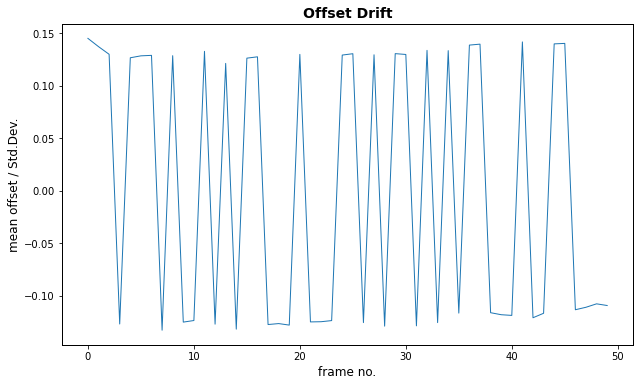

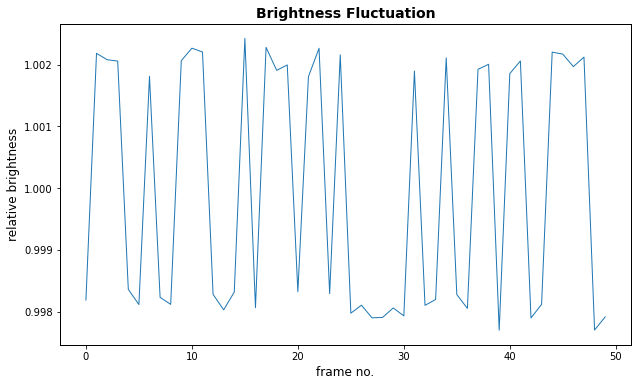

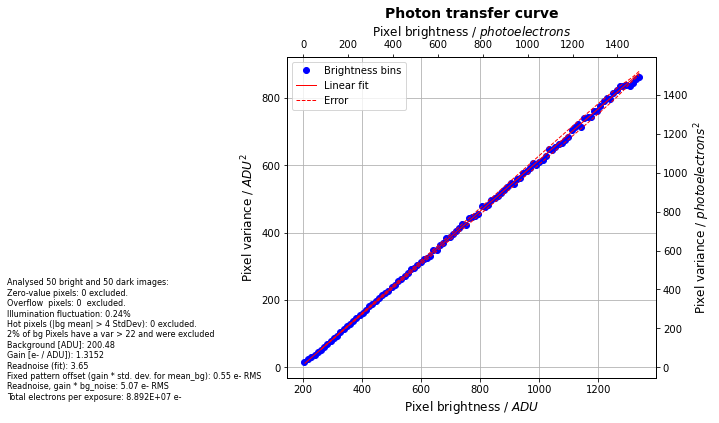

In [175]:
# Quantum efficiencies can be measured. After running this cell, skip to cell
# "Photon rate and Quantum Efficiency" and uncomment the g001 or b001 loading
# procedure 

# ------------------------------------------------
# A good quality curve
EXPOSURE = 500e-3
# ------------------------------------------------
# # # Green source
# bg_file = data_dir/r"CalibrationImages\iXon897\2020-07-21\dark.tif"
# fg_file = data_dir/r"CalibrationImages\iXon897\2020-07-21\g001.tif"
# # load source info
# # g001 2020-07
# responsivity_cert = pd.read_csv(data_dir/r"pm_responsivity\certificate_01.csv"
#                            , index_col="Wavelength")["Without filter"]
# cal_source_power = pm_container()
# cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
#                         data_dir/r"source_measurements\2020-07\g-001.csv",
#                         data_dir/r"source_measurements\2020-07\dark.csv") 
# cal_source_power.load_responsivity(responsivity_cert)
# cal_source_power.load_emission_spectrum(g001_o)
# ------------------------------------------------
# Blue source
bg_file = data_dir/r"CalibrationImages\iXon897\2020-07-21\dark.tif"
fg_file = data_dir/r"CalibrationImages\iXon897\2020-07-21\b001.tif"
# b001 2020-07
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2020-07\b-001.csv",
                        data_dir/r"source_measurements\2020-07\dark.csv") 
cal_source_power.load_responsivity(responsivity_cert)
cal_source_power.load_emission_spectrum(b001_o)

#-------------------------------------------------------
# Andor ixon 897 Quoted QE
extr_qe = pd.read_csv(data_dir/r"camera_information\iXon-897\manually_read_qe.csv", index_col=0)
extr_qe["QE"] = extr_qe["QE BV"]
#-------------------------------------------------------

fg, bg = nip.readim(str(fg_file)), nip.readim(str(bg_file))
fg, bg = fg[-100:,:,:].astype(float), bg[-100:,:,:].astype(float)
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(fg, bg)
e_rate = mean_el_per_exposure/EXPOSURE
e_rate

No module named 'bioformats'
No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 100 bright and 100 dark images:
Zero-value pixels: 0 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 4.96%
Hot pixels (|bg mean| > 4 StdDev): 0 excluded.
2% of bg Pixels have a var > 24 and were excluded
Background [ADU]: 102.76
Gain [e- / ADU]): 8.6558
Readnoise (fit): 36.04
Fixed pattern offset (gain * std. dev. for mean_bg): 0.58 e- RMS
Readnoise, gain * bg_noise: 36.67 e- RMS
Total electrons per exposure: 5.568E+07 e- 



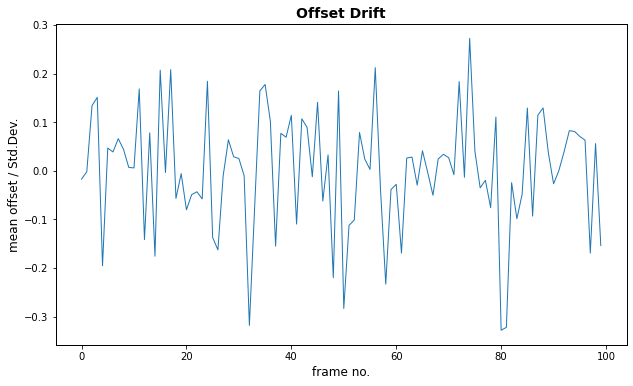

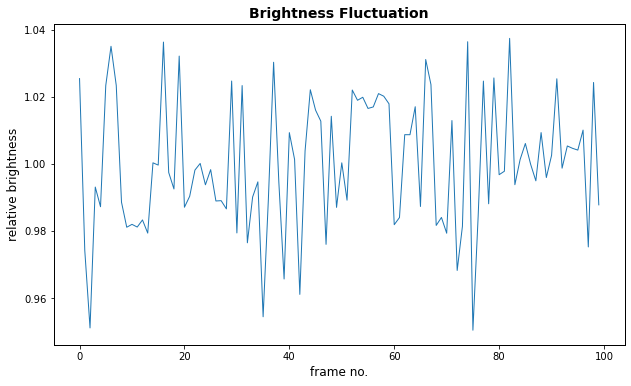

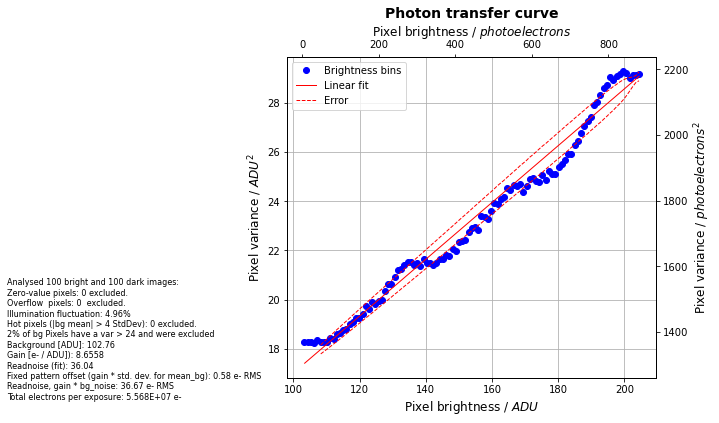

In [214]:
# ------------------------------------------------
# A dubious wavey curve. 
bg_file = data_dir/r"CalibrationImages\iXon3\2021-05\dark\bg.tif"
fg_file = data_dir/r"CalibrationImages\iXon3\2021-05\g001\fg.tif"
# ------------------------------------------------

fg, bg = nip.readim(str(fg_file)), nip.readim(str(bg_file))
fg, bg = fg[-100:,:,:].astype(float), bg[-100:,:,:].astype(float)
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(fg, bg)


### Orca Flash

No module named 'bioformats'
No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 50 bright and 50 dark images:
Zero-value pixels: 2 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 0.07%
Hot pixels (|bg mean| > 4 StdDev): 218 excluded.
2% of bg Pixels have a var > 53 and were excluded
Background [ADU]: 100.90
Gain [e- / ADU]): 0.4510
Readnoise (fit): 0.77
Fixed pattern offset (gain * std. dev. for mean_bg): 1.05 e- RMS
Readnoise, gain * bg_noise: 1.43 e- RMS
Total electrons per exposure: 1.119E+08 e- 

223788293.8762828


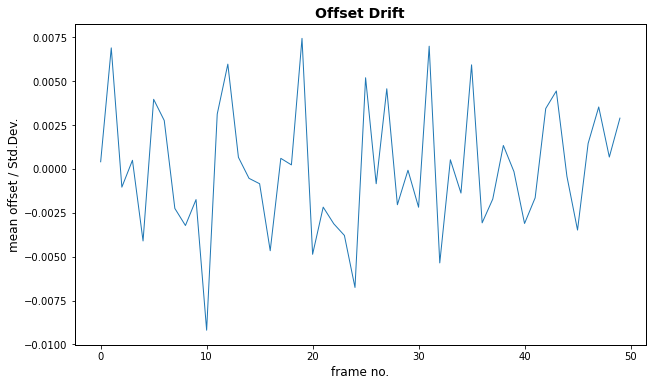

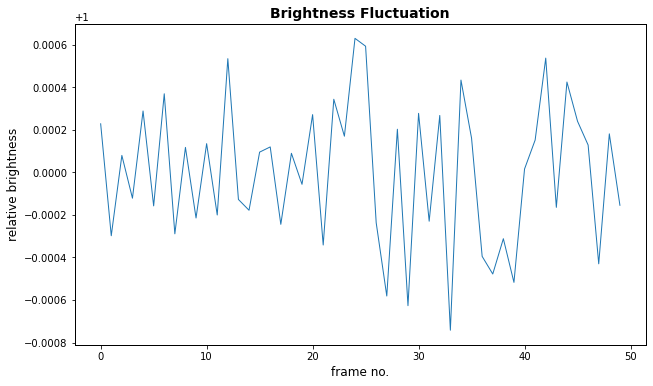

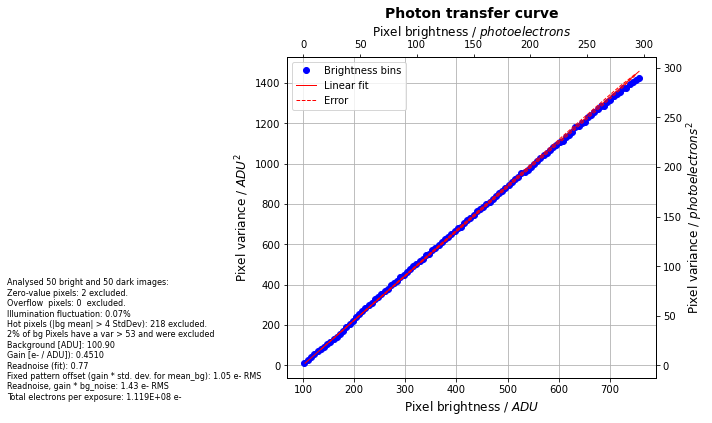

In [150]:
# Quantum efficiencies can be measured. After running this cell, skip to cell
# "Photon rate and Quantum Efficiency" and run

# -----------------------------------------------------------------------------
# Green source
EXPOSURE = 500/1000
# -----------------------------------------------------------------------------
fg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-07\g001.tif"
bg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-07\dark.tif"
# load source info
# g001 2020-07
responsivity_cert = pd.read_csv(data_dir/r"pm_responsivity\certificate_01.csv"
                           , index_col="Wavelength")["Without filter"]
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2020-07\g-001.csv",
                        data_dir/r"source_measurements\2020-07\dark.csv") 
cal_source_power.load_responsivity(responsivity_cert)
cal_source_power.load_emission_spectrum(g001_o)

# -----------------------------------------------------------------------------
# Orca Flash 4.0 quoted QE
extr_qe = pd.read_csv(data_dir/r"camera_information\OrcaFlash4.0\manually_read_qe.csv", index_col=0)
extr_qe["QE"] = extr_qe["QE_paper"]
#-------------------------------------------------------

fg, bg = nip.readim(str(fg_file)), nip.readim(str(bg_file))
fg, bg = fg[-50:].astype(float), bg[-50:,].astype(float)
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(
    fg, bg)
e_rate = mean_el_per_exposure/EXPOSURE
e_rate

In [ ]:
# Quantum efficiencies can be measured. After running this cell, skip to cell
# "Photon rate and Quantum Efficiency" and run

# -----------------------------------------------------------------------------
# Blue source
# -----------------------------------------------------------------------------
EXPOSURE = 500/1000
fg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-07\b001.tif"
bg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-07\dark.tif"
# b001 2020-07
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2020-07\b-001.csv",
                        data_dir/r"source_measurements\2020-07\dark.csv") 
cal_source_power.load_responsivity(responsivity_cert)
cal_source_power.load_emission_spectrum(b001_o)
# -----------------------------------------------------------------------------
# Orca Flash 4.0 quoted QE
extr_qe = pd.read_csv(data_dir/r"camera_information\OrcaFlash4.0\manually_read_qe.csv", index_col=0)
extr_qe["QE"] = extr_qe["QE_paper"]
#-------------------------------------------------------

fg, bg = nip.readim(str(fg_file)), nip.readim(str(bg_file))
fg, bg = fg[-50:].astype(float), bg[-50:,].astype(float)
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(
    fg, bg)
e_rate = mean_el_per_exposure/EXPOSURE
e_rate

No module named 'bioformats'
No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 50 bright and 50 dark images:
Zero-value pixels: 30 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 0.83%
Hot pixels (|bg mean| > 4 StdDev): 87 excluded.
2% of bg Pixels have a var > 105 and were excluded
Background [ADU]: 101.28
Gain [e- / ADU]): 0.4499
Readnoise (fit): 1.23
Fixed pattern offset (gain * std. dev. for mean_bg): 23.62 e- RMS
Readnoise, gain * bg_noise: 1.69 e- RMS
Total electrons per exposure: 5.018E+06 e- 

250883641.66496545


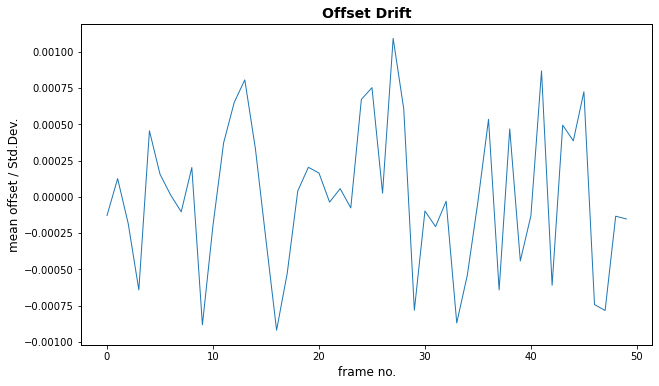

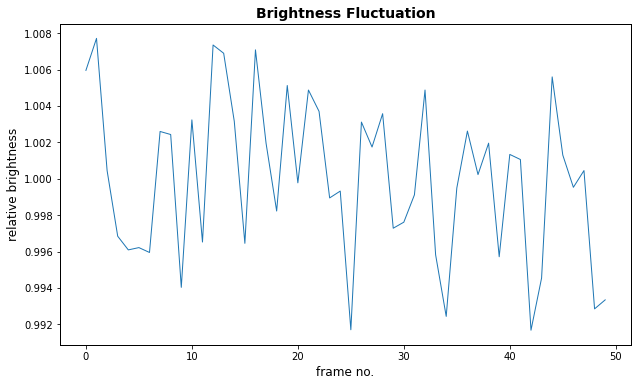

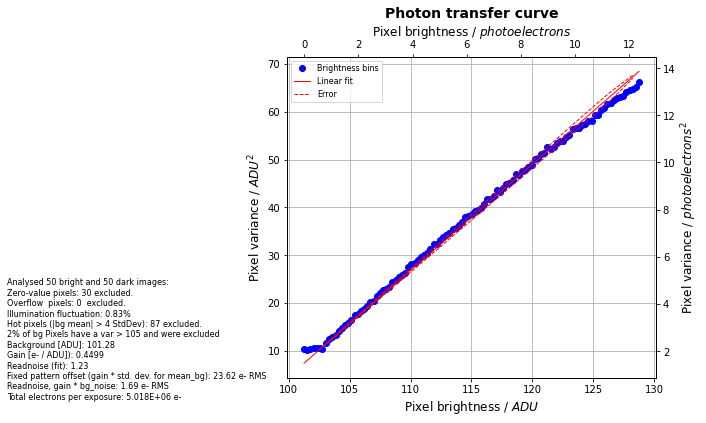

In [171]:
# Data associated with ptc plot in main article.
# Skip to save plots section

# -----------------------------------------------------------------------------
EXPOSURE = 20/1000
fg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-05\20ms\g001.tif"
bg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-05\20ms\dark.tif"
#-------------------------------------------------------

fg, bg = nip.readim(str(fg_file)), nip.readim(str(bg_file))
fg, bg = fg[-50:].astype(float), bg[-50:,].astype(float)
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(
    fg, bg, exportpath=out_dir)
e_rate = mean_el_per_exposure/EXPOSURE
e_rate

No module named 'bioformats'
No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 50 bright and 50 dark images:
Zero-value pixels: 35 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 4.86%
Hot pixels (|bg mean| > 4 StdDev): 97 excluded.
0% of bg Pixels have a var > 207343 and were excluded
Background [ADU]: 101.72
Gain [e- / ADU]): 0.4564
Readnoise (fit): 1.63
Fixed pattern offset (gain * std. dev. for mean_bg): 9.45 e- RMS
Readnoise, gain * bg_noise: 1.71 e- RMS
Total electrons per exposure: 1.220E+06 e- 

243950031.1726267


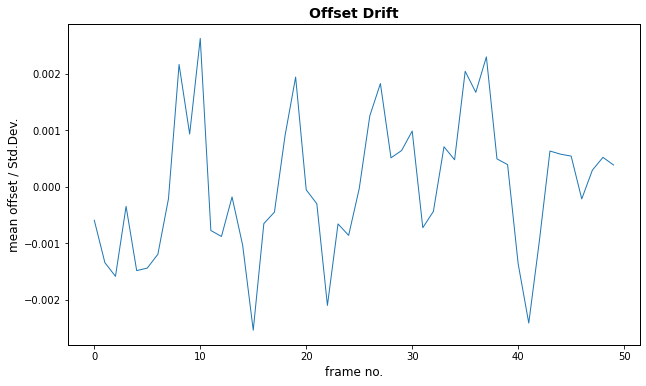

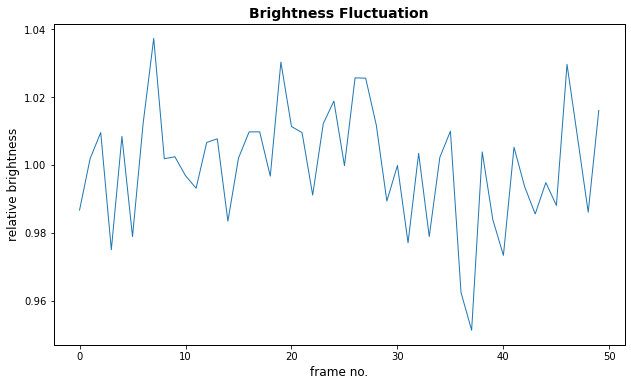

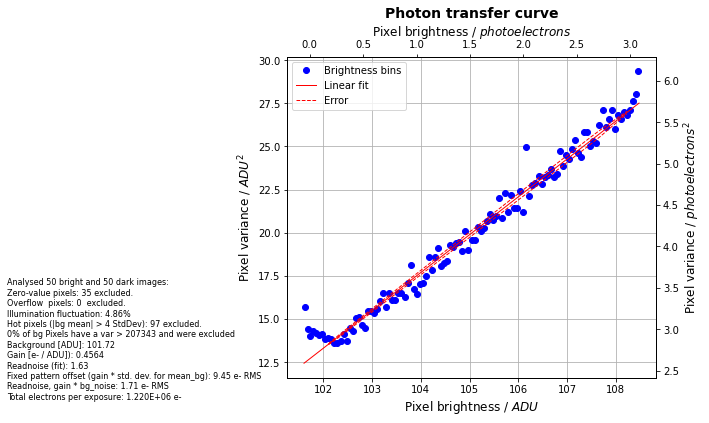

In [209]:
# RTS limited plot
# run this with  crazyPixelPercentile=100 to include all high variance pixels
# -----------------------------------------------------------------------------
EXPOSURE = 5/1000
fg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-05\5ms\bright.tif"
bg_file = data_dir/r"CalibrationImages\OrcaFlash40\2020-05\5ms\dark.tif"
#-------------------------------------------------------

fg, bg = nip.readim(str(fg_file)), nip.readim(str(bg_file))
fg, bg = fg[-50:].astype(float), bg[-50:,].astype(float)
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(
    fg, bg, exportpath=out_dir, crazyPixelPercentile=100)
    # fg, bg, exportpath=out_dir, crazyPixelPercentile=98)
e_rate = mean_el_per_exposure/EXPOSURE
e_rate

### PCO

No module named 'bioformats'
No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 40 bright and 40 dark images:
Zero-value pixels: 0 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 0.46%
Hot pixels (|bg mean| > 4 StdDev): 3962 excluded.
2% of bg Pixels have a var > 103 and were excluded
Background [ADU]: 104.84
Gain [e- / ADU]): 0.6108
Readnoise (fit): 2.75
Fixed pattern offset (gain * std. dev. for mean_bg): 2.67 e- RMS
Readnoise, gain * bg_noise: 2.78 e- RMS
Total electrons per exposure: 2.257E+07 e- 

2.26e+08


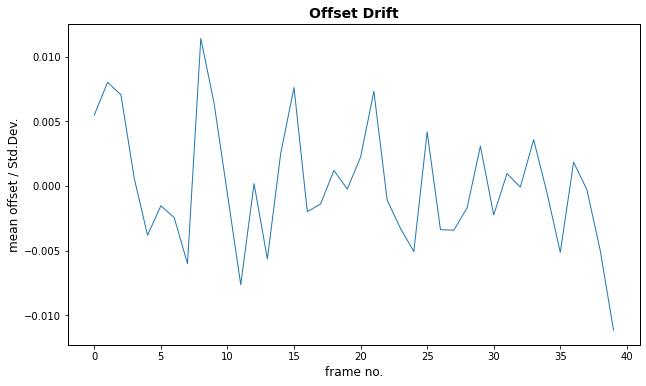

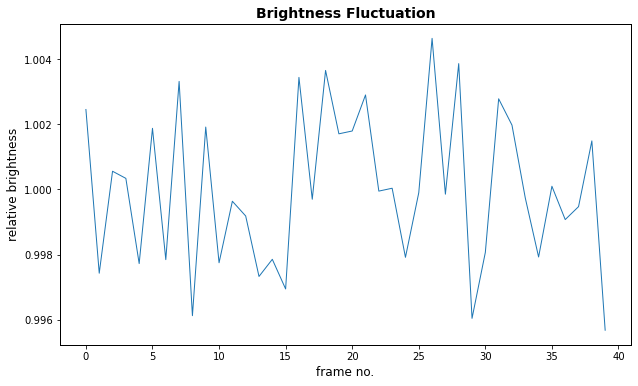

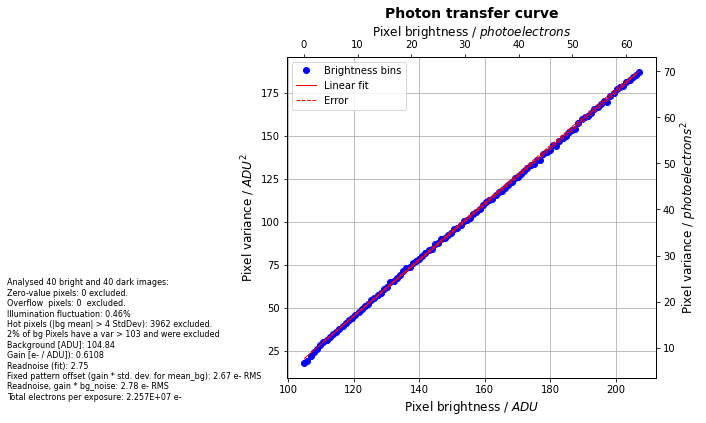

In [234]:
# Quantum efficiencies can be measured. After running this cell, skip to cell
# "Photon rate and Quantum Efficiency" and run
# -----------------------------------------------------------------------------
# PCO quoted QE
extr_qe = pd.read_csv(data_dir/r"camera_information\PCO\manually_read_qe.csv", index_col=0)
extr_qe["QE"] = extr_qe["QE"]
#-------------------------------------------------------
EXPOSURE = 100e-3

# load source info
# g001 2020-07
responsivity_cert = pd.read_csv(data_dir/r"pm_responsivity\certificate_01.csv"
                           , index_col="Wavelength")["Without filter"]
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2020-08\g-001.csv",
                        data_dir/r"source_measurements\2020-08\dark.csv") 
cal_source_power.load_responsivity(responsivity_cert)
cal_source_power.load_emission_spectrum(g001_o)

bg_file = data_dir/r"CalibrationImages\PCO\dark.tif"
fg_file = data_dir/"CalibrationImages\PCO\g001.tif"

# --------------------------------------
EXPOSURE = 100e-3
# bg_file = data_dir/r"CalibrationImages\PCO\dark.tif"
# fg_file = data_dir/r"CalibrationImages\PCO\b001.tif"

# # b001 2020-07
# cal_source_power = pm_container()
# cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
#                         data_dir/r"source_measurements\2020-07\b-001.csv",
#                         data_dir/r"source_measurements\2020-07\dark.csv") 
# cal_source_power.load_responsivity(responsivity_cert)
# cal_source_power.load_emission_spectrum(b001_o)



fg, bg = nip.readim(str(fg_file)).astype(float), nip.readim(str(bg_file)).astype(float)
fg, bg = fg[-40:,], bg[-40:,] 
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(
    fg, bg)
e_rate = mean_el_per_exposure/EXPOSURE
print(f"{e_rate:.2e}")

No module named 'bioformats'
No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 40 bright and 40 dark images:
Zero-value pixels: 0 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 0.78%
Hot pixels (|bg mean| > 4 StdDev): 3962 excluded.
2% of bg Pixels have a var > 103 and were excluded
Background [ADU]: 104.84
Gain [e- / ADU]): 0.6060
Readnoise (fit): 2.74
Fixed pattern offset (gain * std. dev. for mean_bg): 2.67 e- RMS
Readnoise, gain * bg_noise: 2.76 e- RMS
Total electrons per exposure: 1.578E+07 e- 

1.58e+08


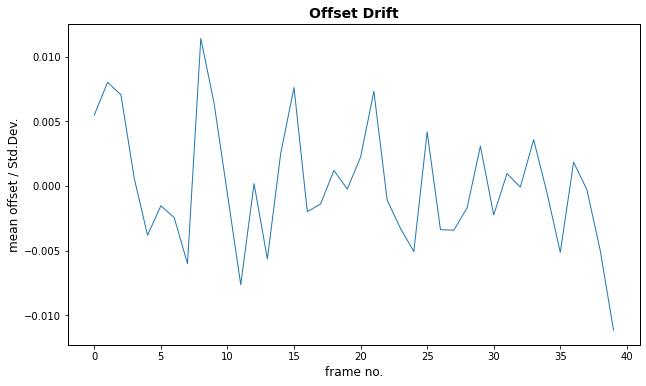

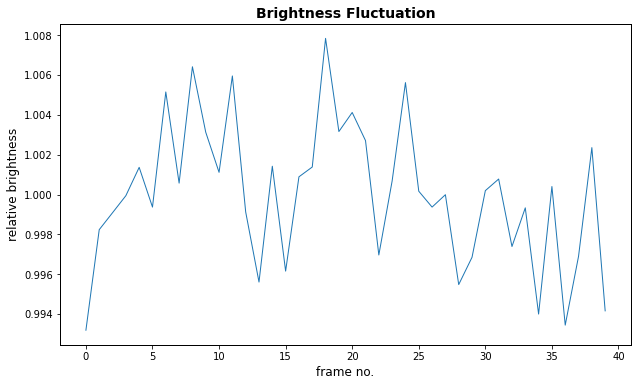

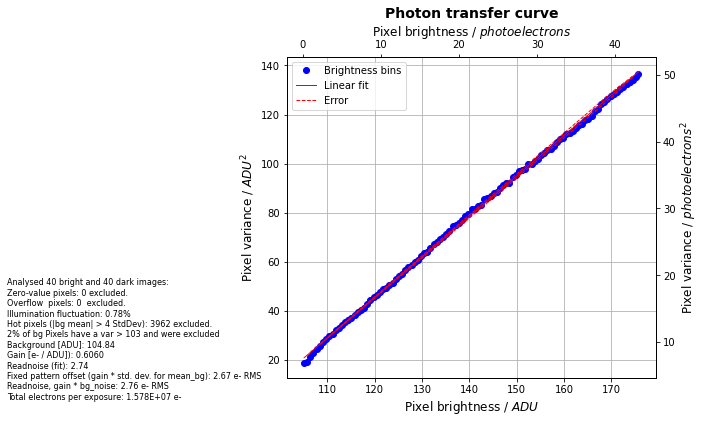

In [238]:
# Quantum efficiencies can be measured. After running this cell, skip to cell
# "Photon rate and Quantum Efficiency" and run
# -----------------------------------------------------------------------------
# PCO quoted QE
extr_qe = pd.read_csv(data_dir/r"camera_information\PCO\manually_read_qe.csv", index_col=0)
extr_qe["QE"] = extr_qe["QE"]
#-------------------------------------------------------
EXPOSURE = 100e-3
bg_file = data_dir/r"CalibrationImages\PCO\dark.tif"
fg_file = data_dir/r"CalibrationImages\PCO\b001.tif"

# b001 2020-07
cal_source_power = pm_container()
cal_source_power.unbiased_power, cal_source_power.pm_wavelength = power_read_subtract_dark(
                        data_dir/r"source_measurements\2020-07\b-001.csv",
                        data_dir/r"source_measurements\2020-07\dark.csv") 
cal_source_power.load_responsivity(responsivity_cert)
cal_source_power.load_emission_spectrum(b001_o)



fg, bg = nip.readim(str(fg_file)).astype(float), nip.readim(str(bg_file)).astype(float)
fg, bg = fg[-40:,], bg[-40:,] 
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(
    fg, bg)
e_rate = mean_el_per_exposure/EXPOSURE
print(f"{e_rate:.2e}")

### Photometrics Prime BSI

No module named 'bioformats'
No module named 'bioformats'
Calibration results:
[-2, -1]
[-2, -1]
Analysed 50 bright and 50 dark images:
Zero-value pixels: 0 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 0.96%
Hot pixels (|bg mean| > 4 StdDev): 0 excluded.
2% of bg Pixels have a var > 54 and were excluded
Background [ADU]: 99.57
Gain [e- / ADU]): 0.4248
Readnoise (fit): 1.72
Fixed pattern offset (gain * std. dev. for mean_bg): 1.44 e- RMS
Readnoise, gain * bg_noise: 2.02 e- RMS
Total electrons per exposure: 3.154E+07 e- 

2.10e+08


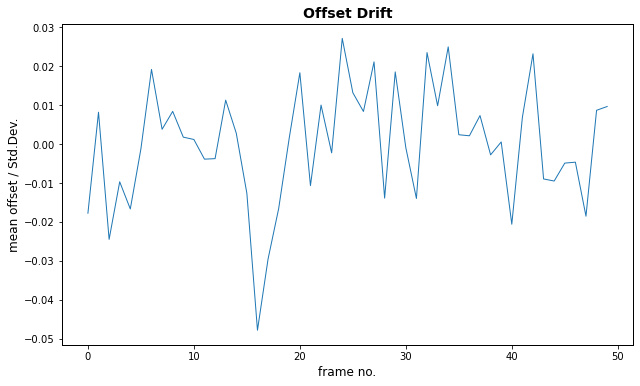

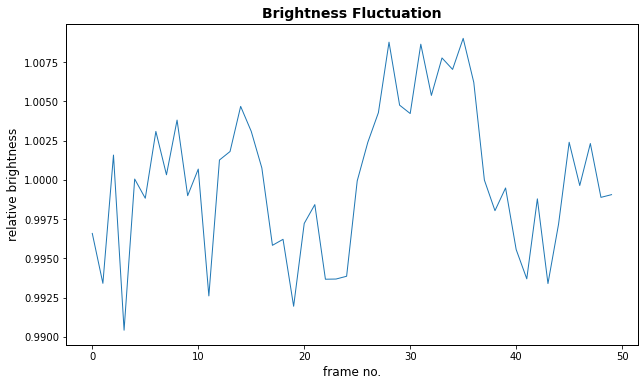

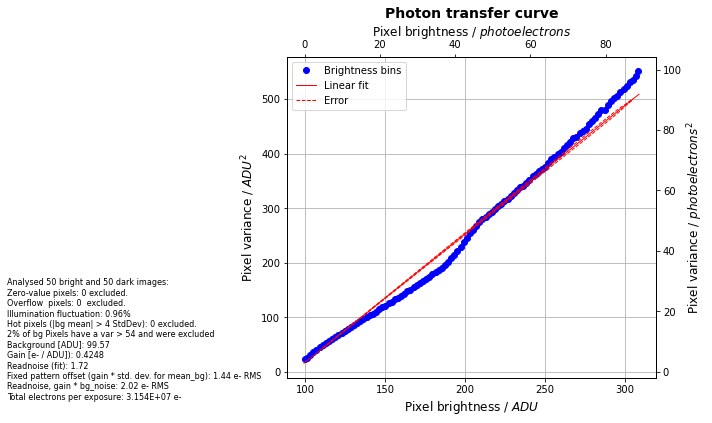

In [165]:
# produces a curve with a bend
# ------------------------------------------------
EXPOSURE = 150e-3
fg_file = data_dir/r"CalibrationImages\PhotometricsPrime\2020-02\bright.tif"
bg_file = data_dir/r"CalibrationImages\PhotometricsPrime\2020-02\dark.tif"
# ------------------------------------------------
fg, bg = nip.readim(str(fg_file)), nip.readim(str(bg_file))

fg, bg = fg[:].astype(float), bg[:].astype(float)

# fit before bend
(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(fg, bg)

# (bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(fg, bg, validRange=(100,180))
# fir after bend
# (bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(fg, bg, validRange=(220,300))
e_rate = mean_el_per_exposure/EXPOSURE
print(f"{e_rate:.2e}")

### Allied Vision

Calibration results:
[-2, -1]
[-2, -1]
Analysed 200 bright and 200 dark images:
Zero-value pixels: 0 excluded.
Overflow  pixels: 0  excluded.
Illumination fluctuation: 12.01%
Hot pixels (|bg mean| > 4 StdDev): 4334 excluded.
2% of bg Pixels have a var > 4 and were excluded
Background [ADU]: 62.63
Gain [e- / ADU]): 2.7670
Readnoise (fit): 4.38
Fixed pattern offset (gain * std. dev. for mean_bg): 4.36 e- RMS
Readnoise, gain * bg_noise: 4.46 e- RMS
Total electrons per exposure: 2.695E+07 e- 



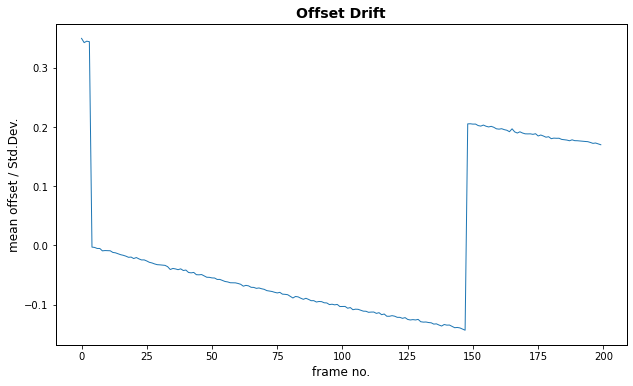

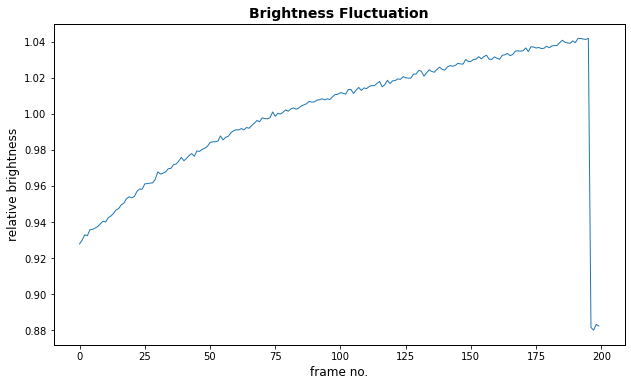

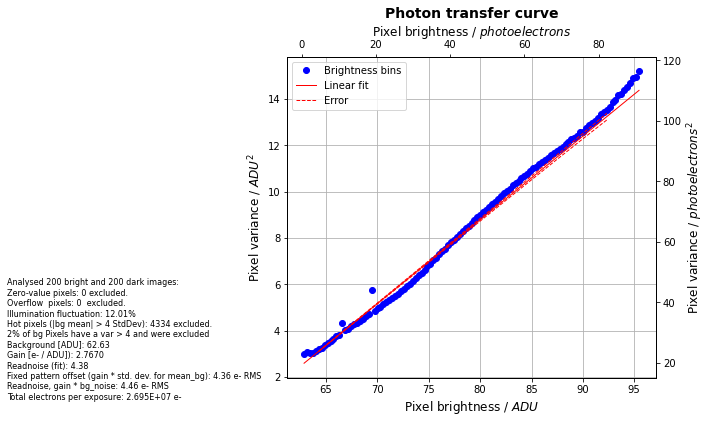

In [213]:
# Big fluctuation in offset and brightness
# This only needs to be run here

fg = np.load(data_dir/r"CalibrationImages\Alliedvision\g002\g002.npy")
bg = np.load(data_dir/r"CalibrationImages\Alliedvision\dark\dark.npy")


(bg_total_mean, gain, Readnoise, mean_el_per_exposure, valid_map, figures, *rest) = nip.cal_readnoise(
                        fg, bg, exportpath=out_dir)

## Save plots

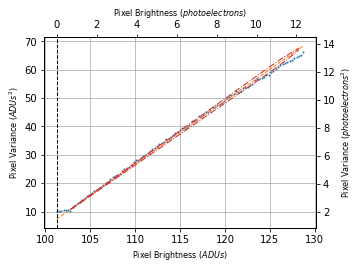

In [172]:
# Generate plots that are more appropriate for publication. Run this cell after
# calling one of the above image loading and calibration cells

offset_plot, brightness_plot, ptc_plot = figures

a = ptc_plot.gca()
data_lines = []
for line in a.lines:
    data_lines.append(np.array(line.get_xydata()))

offset = bg_total_mean
#------------------------------------------------------------

plt.close("all")


# true for 2021-06 version
var_bins = data_lines[0]
fit_line = data_lines[1]
error_line_1 = data_lines[2]
error_line_2 = data_lines[3]

fig, ax = plt.subplots()

ax.plot(var_bins[:,0], var_bins[:,1], ".", markersize=2)
# ax.plot(var_bins[:,0], var_bins[:,1], ".", color="black", markersize=2)
ax.plot(fit_line[:,0], fit_line[:,1], ls="--")
ax.plot(error_line_1[:,0], error_line_1[:,1], color="tab:red", ls="-.")
ax.plot(error_line_2[:,0], error_line_2[:,1], color="tab:red", ls="-.")

ax.set_ylabel("Pixel Variance ($ADUs^2$)")
ax.set_xlabel("Pixel Brightness ($ADUs$)")


# plt.axvline(offset, color="tab:red", ls="--")
ax.axvline(offset, color="black", ls="--")

CM = 1/2.54
fig.set_size_inches(FIGSIZE_LARGE)
plt.tight_layout()

def adu2el(adu):
    return (adu-offset)*gain
def el2adu(el):
    return el/gain+offset

secax_x = ax.secondary_xaxis('top', functions=(adu2el, el2adu))
secax_y = ax.secondary_yaxis('right', functions=(lambda x: x*gain**2, lambda x: x/gain**2))

secax_x.set_xlabel("Pixel Brightness ($photoelectrons$)")
secax_y.set_ylabel("Pixel Variance ($photoelectrons^2$)")

plt.grid()

# fig.subplots_adjust(right=0.87, top=0.8)
fig.tight_layout()
# ax.set_title("Photon transfer curve")

# plt.xlim(95, 130), plt.ylim(-2, 75)

fig.savefig(out_dir/"ptc.png", dpi=300)
fig.savefig(out_dir/"ptc.eps")
    

## Photon rate and Quantum Efficiency

In [240]:
cal_source_power.process()
print(f"Corrected power: {cal_source_power.corrected_power:.4E}")
print(f"Power weighted mean wavelength: {cal_source_power.pw_mean_wl:.2E}")
print(f"Expected Photon Rate: {cal_source_power.photon_flux:.2E}")
quantum_efficiency = float(e_rate/cal_source_power.photon_flux)
print("Electron Rate = {:.2E}".format(e_rate))
print("Quantum efficiency = {:.1f}%".format(quantum_efficiency*100))

Corrected power: 1.0181E-10
Power weighted mean wavelength: 4.61E+02
Expected Photon Rate: 2.36E+08
Electron Rate = 1.58E+08
Quantum efficiency = 66.8%


## Quoted QE

In [241]:
cam_qe = pd.DataFrame()
cam_qe["PowerDensity"] = cal_source_power.spectrum["Power density"]
cam_qe["Quoted QE"] = np.interp(cam_qe.index, extr_qe.index, extr_qe["QE"])

from scipy.constants import c, h

VIS_RANGE = slice(370, 750) # limits defined by spectrometer specs

cam_qe["PhotonEnergy"] = (h*c)/(cam_qe.index*1e-9)
cam_qe["PhotonDensity"] = cam_qe["PowerDensity"]/cam_qe["PhotonEnergy"]
integrated_qe = (((cam_qe["Quoted QE"]*cam_qe["PhotonDensity"]*np.gradient(cam_qe.index))[VIS_RANGE]).sum()/
                ((cam_qe["PhotonDensity"]*np.gradient(cam_qe.index))[VIS_RANGE]).sum())

print(f"Integrated QE: {integrated_qe:.1f}%")
print(f"Error of our Measurement: {(quantum_efficiency-integrated_qe/100):.1%}%")

Integrated QE: 73.0%
Error of our Measurement: -6.2%%
